# Chinese-Clip with OpenVINO™

This notebook demonstrates the use of OpenVINO and the end-to-end machine learning embedding open-source library Towhee for Chinese image-text similarity matching tasks. The CLIP model used in this notebook is trained in a self-supervised manner on hundreds of millions or billions of (image, text) pairs. It extracts feature vector embeddings from input images and texts, enabling tasks such as image classification and similarity search based on feature similarity. The zero-shot classification performance of the CLIP model can achieve results comparable to supervised training on ImageNet using the ResNet model, with improved generalization and abstraction capabilities.

Thanks to the relatively small computational cost of the CLIP model and the optimization effects of OpenVINO, we can effectively replicate this inference process on personal computers.

本教程出自 https://mp.weixin.qq.com/s/_Hqvy2gU_6T3bkHDO2ToXg

作者 https://github.com/sanbuphy

这个 notebook 演示了使用 OpenVINO 与端到端机器学习 Embedding 开源库 Towhee 进行中文图文相似性匹配任务：其中使用的CLIP模型以自监督的方式在数亿或数十亿（图像，文本）对上进行训练，它从输入图像和文本中提取特征向量embedding，根据特征相似度匹配可完成图像分类和相似查找任务。CLIP模型的zero-shot分类效果就能达到在Imagenet上监督训练的ResNet分类效果，且有更好的泛化和抽象能力。

得益于 Clip 模型较小的计算开销与 OpenVINO 的优化效果，我们能够在家用电脑上良好的复现这一推理流程。

## CLIP原理

CLIP模型是来自OpenAI的经典图文表征模型，其采用双塔模型结构（如下图），利用大规模图文对平行语料进行对比学习，从而能够实现图片和文本的跨模态语义特征抽取。

![](https://www.modelscope.cn/api/v1/models/damo/multi-modal_clip-vit-base-patch16_zh/repo?Revision=master&FilePath=resources/clip_model.png&View=true)

原始的CLIP模型基于英文图文语料，不能用于中文的图文表征提取场景。达摩院的中文CLIP以英文CLIP视觉侧参数和中文Roberta参数，作为模型初始化值，使用大规模中文数据进行训练（~2亿图文对）；最终可用于图文检索和图像、文本的表征提取，应用于搜索、推荐等应用场景。通过如下图所示的二阶段预训练策略（一阶段仅训练文本侧，二阶段同时训练），实现了CLIP模型的中文化版本。

![](https://www.modelscope.cn/api/v1/models/damo/multi-modal_clip-vit-base-patch16_zh/repo?Revision=master&FilePath=resources/chinese_clip_pretrain.png&View=true)

### CLIP应用

CLIP可以应用于各类不同的场景：

Zero Shot 分类：将图像与类别文本相比较，以得到最接近的分类结果。（例如：图像分类）  
Retrieval：对于给定的输入文本和图像，在大量文本与图像数据中找到最匹配的结果。（例如：clip-retrieval）   
CLIP Guidance: 对于图像生成模型，结合生成结果与输入文本间的CLIP距离生成更好的图片（例如：VQGAN+CLIP）。   
CLIP Captioning: 利用 CLIP encoding 提取特征，以该特征的映射结果结合 GPT2 生成 caption.（例如：ClipCap）

在这个 notebook 中，你将学会如何使用 Clip 进行Zero Shot 分类，以及处理简单的文字与图像检索任务。

### Table of content:
- [Download the Model](#Download-the-Model-Uparrow)
- [Load model](#Load-model-Uparrow)
- [Data Processing](#Data-Processing-Uparrow)
- [Visualize data](#Visualize-data-Uparrow)
- [Main Processing Function](#Main-Processing-Function-Uparrow)
- [Run](#Run-Uparrow)
- [More Cases](#More-Cases-Uparrow)

In [ ]:
%pip install "openvino-dev>=2023.1.0" -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import openvino as ov
from clip_tokenizer import tokenize
from typing import List

## Download the Model [$\Uparrow$](#Table-of-content:)

为节省时间，这里提供了中文 clip onnx 模型的直接下载地址；你也可以根据[导出教程](https://github.com/OFA-Sys/Chinese-CLIP/blob/master/deployment.md)自行导出 onnx 模型。值得注意的是，OpenVINO 也支持 Pytorch 模型到 OpenVINO IR 的转换方式，如果有兴趣你可以参考[转换教程](https://docs.openvino.ai/2023.1/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_PyTorch.html)与源码自行转换直接得到 OpenVINO 模型。

（注意：在这里只导出了 base 的模型，如果你发现在部分任务下效果不是很好，可以尝试 large 模型或者进行微调，中文 Clip 的官方仓库中提供了所有的可参考资料）

模型和测试数据的相关下载地址：

https://github.com/towhee-io/data/releases/download/chinese-clip/chinese_clip.zip

解压后，将该 notebook 拖入解压的文件夹中


## Load model [$\Uparrow$](#Table-of-content:)
准备用于结果预测通用模型类，包括模型的初始化与推理。

OpenVINO模型初始化有四个主要步骤：

1. 初始化OpenVINO Runtime。
2. 从模型文件中读取网络和权重（支持 pytorch onnx paddle tensorflow vinoIR多种中间格式的直接读取）。
3. 将模型编译为设备可用的形式。
4. 获取并准备节点的输入和输出名称。
   
我们可以将它们放在一个类的构造函数中。为了让OpenVINO自动选择最佳设备进行推理，只需使用“AUTO”。大多数情况下，最佳设备是“GPU”（性能更好，但启动时间稍长）。

In [3]:
core = ov.Core()

class VinoModel:
    def __init__(self, model_path, device="AUTO"):
        self.model = core.read_model(model=model_path)
        self.input_layer = self.model.input(0)
        self.input_shape = self.input_layer.shape
        self.height = self.input_shape[2]
        self.width = self.input_shape[3]
        print("input shape:",self.input_layer.shape)
        print("input names:",self.input_layer.names)
        self.compiled_model = core.compile_model(model=self.model, device_name=device)
        self.output_layer = self.compiled_model.output(0)
        print("output names:",self.output_layer.names)

    def predict(self, input):
        result = self.compiled_model(input)[self.output_layer]
        return result

In [4]:
img_model = VinoModel("image_model.onnx")

input shape: [1,3,224,224]
input names: {'image'}
output names: {'unnorm_image_features'}


In [5]:
txt_model = VinoModel("text_model.onnx")

input shape: [1,52]
input names: {'text'}
output names: {'unnorm_text_features'}


## Data Processing [$\Uparrow$](#Table-of-content:)

在输入 OpenVINO 引擎推理之前，我们需要对数据进行适当的预处理操作，数据预处理函数改变输入数据的布局和形状以适配网络输入格式。


In [6]:
def preprocess(image:np.ndarray):
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC).astype(np.float32) / 255.0
    mean = np.array([0.48145466, 0.4578275, 0.40821073])
    std = np.array([0.26862954, 0.26130258, 0.27577711])
    image = (image - mean) / std
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image,axis=0).astype(np.float32)
    return image

## Visualize data [$\Uparrow$](#Table-of-content:)

接下来我们将进行 Clip 模型的推理，我们选择一个皮卡丘的图片作为推理对象

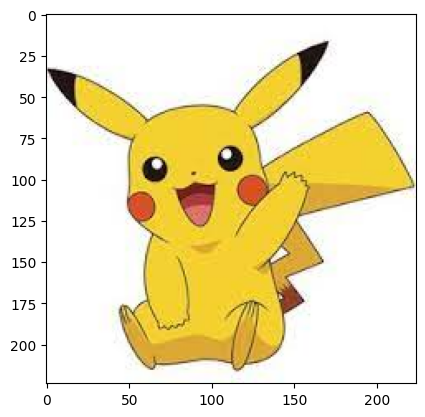

In [7]:
from PIL import Image
image =np.array(Image.open('./pokemon.jpeg'))
plt.imshow(image)

## Main Processing Function [$\Uparrow$](#Table-of-content:)

在核心处理函数中，我们需要分别提取图像和文本的 Embedding 特征，归一化后一一匹配得到最接近的特征结果。

In [11]:
def _img_feature(input_img:np.ndarray):
    image_features = img_model.predict(input_img)
    img_norm = np.linalg.norm(image_features, axis=-1, keepdims=True)
    image_features /= img_norm
    return image_features

def _text_feature(input_text:List[str]):
    text = tokenize(input_text, context_length=52) 
    text_features = []
    for i in range(len(text)):
        one_text = np.expand_dims(text[i],axis=0)
        text_feature = txt_model.predict(one_text)[0]
        text_features.append(text_feature)
    text_features = np.stack(text_features, axis=0)
    txt_norm = np.linalg.norm(text_features, axis=1, keepdims=True)
    text_features /= txt_norm
    return text_features

def run_clip(image:np.ndarray,input_strs:List[str]):
    image_features = _img_feature(preprocess(image))
    text_features = _text_feature(input_strs)
    logits_per_image = 100 * np.dot(image_features, text_features.T)
    exp_logits = np.exp(logits_per_image - np.max(logits_per_image, axis=-1, keepdims=True))
    max_logit = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
    max_str = input_strs[max_logit.argmax()]
    max_str_logit = max_logit.max()
    return max_str, max_str_logit

## Run [$\Uparrow$](#Table-of-content:)

我们可以初始化一个字符串列表，从而得到该图最匹配的一个文本信息。

你可以构建一个自己想要进行分类的字符串列表，从而达到在不同任务上分类的目的。


In [9]:
text = ["杰尼龟", "妙蛙种子", "小火龙", "皮卡丘"]
max_str, max_str_logit = run_clip(image,text)
print(f"最大概率：{max_str_logit}, 对应类别：{max_str}")

最大概率：0.9436785578727722, 对应类别：皮卡丘


## More cases [$\Uparrow$](#Table-of-content:)

接下来，我们将利用端到端机器学习 Embedding 开源库 Towhee 以及 Meta 向量数据库 Faiss ，构建一个高效的文图检索与图图检索引擎。通过在边缘设备上部署检索引擎，我们能够有效地筛选和总结推理检测结果，从而更好地进行综合统计分析。

此外，Chinese-Clip 同时提供了微调的接口，通过对指定商品数据的微调，你可以结合检索引擎实现一个商品检索装置，抑或是端侧商品推荐系统。

（注意：这里只是一个范例，你可以使用端侧设备得到 Embedding 但使用云端数据库进行匹配，又或者是利用它减少端侧数据的筛选时间。）

在开始之前，你需要手动解压 images.zip 文件至当前文件夹用于图片检索，并安装所需的全部环境

In [ ]:
%pip install towhee faiss-cpu -i https://pypi.tuna.tsinghua.edu.cn/simple

In [13]:
from towhee.operator import PyOperator
from towhee import ops, pipe, DataCollection,register
import glob
@register
class img_embedding(PyOperator):
    def __call__(self, path):
        image = np.array(Image.open(path).convert('RGB'))
        return  _img_feature(preprocess(image))[0]
@register
class text_embedding(PyOperator):
    def __call__(self, input_strs):
        return _text_feature(input_strs)[0]

In [16]:
# 将图像编码数据存入 faiss，需要一定时间，只作为向量数据库演示
faiss_pipe = (
    pipe.input('file_name')
    .map('file_name', 'vec', ops.img_embedding())
    .map(('vec', 'file_name'), (), ops.ann_insert.faiss_index('./faiss', 512)) # 和 embedding size 一致
    .output()
)

images_path = glob.glob("./images/*")
for f_name in images_path:
    faiss_pipe(f_name)

# Flush faiss data into disk. 
faiss_pipe.flush()

接下来我们就能体验到文图检索的便捷：

text,images
吃东西的人,

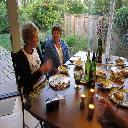
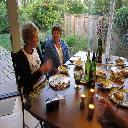
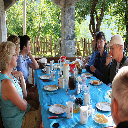
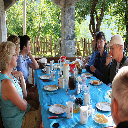
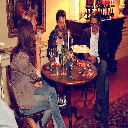

In [17]:
# 第一次运行需要下载
decode = ops.image_decode.cv2('rgb')
text_pipe = (
    pipe.input('text')
    .map('text', 'vec', ops.text_embedding())
    # faiss op result format:  [[id, score, [file_name], ...]
    .map('vec', 'row', ops.ann_search.faiss_index('./faiss', 5))
    .map('row', 'images', lambda x: [decode(item[2][0]) for item in x])
    .output('text', 'images')
)

DataCollection(text_pipe(['吃东西的人'])).show()

In [18]:
from PIL import Image
image =np.array(Image.open('images/000000005082.jpg'))
plt.imshow(image)

不局限于文字搜图，我们还能够实现以图搜图。

img,images
images/000000005082.jpg,

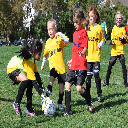
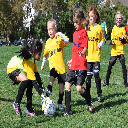
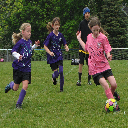
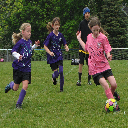
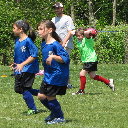

In [19]:
image_pipe = (
    pipe.input('img')
    .map('img', 'vec', ops.img_embedding())
    # faiss op result format:  [[id, score, [file_name], ...]
    .map('vec', 'row', ops.ann_search.faiss_index('./faiss', 5))
    .map('row', 'images', lambda x: [decode(item[2][0]) for item in x])
    .output('img', 'images')
)
DataCollection(image_pipe('images/000000005082.jpg')).show()